In [29]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.metrics import precision_score, recall_score
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

In [18]:
BS = 64
EPOCHS = 5
default_image_size = tuple((128, 128))
learning_rate = 0.001
image_size = 0
directory_root = '../input/plantdisease'
width=128
height=128
depth=3

In [19]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

In [20]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Processing PlantVillage ...
[INFO] Image loading completed


In [21]:
image_size = len(image_list)
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [22]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 69)

[INFO] Spliting data to train, test


In [23]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [25]:
from keras.models import Model
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D
from keras.layers import Dense
from keras.applications.inception_v3 import InceptionV3
from keras.utils.np_utils import to_categorical

# Get the InceptionV3 model so we can do transfer learning
base_inception = InceptionV3(weights='imagenet', include_top=False, 
                             input_shape=(128, 128, 3))
                             
# Add a global spatial average pooling layer
out = base_inception.output
out = GlobalAveragePooling2D()(out)
out = Dense(512, activation='relu')(out)
out = Dense(512, activation='relu')(out)
predictions = Dense(n_classes, activation='softmax')(out)
model = Model(inputs=base_inception.input, outputs=predictions)

# only if we want to freeze layers
for layer in base_inception.layers:
    layer.trainable = False
    
# Compile 
opt = Adam(lr=learning_rate, decay=learning_rate / EPOCHS)
model.compile(loss='categorical_crossentropy', optimizer=opt,metrics=["accuracy"]) 

87916544/87910968 [==============================] - 1s 0us/step


In [26]:
checkpoint = ModelCheckpoint('model.h5', verbose=1, save_best_only=True)
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=40, 
    callbacks=[checkpoint],
    verbose=2
    )

Epoch 1/40

Epoch 00001: val_loss improved from inf to 1.39357, saving model to model.h5
36/36 - 11s - loss: 2.2692 - accuracy: 0.3531 - val_loss: 1.3936 - val_accuracy: 0.5854
Epoch 2/40

Epoch 00002: val_loss improved from 1.39357 to 1.03340, saving model to model.h5
36/36 - 9s - loss: 1.2375 - accuracy: 0.5890 - val_loss: 1.0334 - val_accuracy: 0.6751
Epoch 3/40

Epoch 00003: val_loss did not improve from 1.03340
36/36 - 8s - loss: 1.0899 - accuracy: 0.6321 - val_loss: 1.0435 - val_accuracy: 0.6599
Epoch 4/40

Epoch 00004: val_loss improved from 1.03340 to 0.98517, saving model to model.h5
36/36 - 9s - loss: 1.0570 - accuracy: 0.6408 - val_loss: 0.9852 - val_accuracy: 0.6887
Epoch 5/40

Epoch 00005: val_loss improved from 0.98517 to 0.92646, saving model to model.h5
36/36 - 9s - loss: 0.9187 - accuracy: 0.6987 - val_loss: 0.9265 - val_accuracy: 0.6988
Epoch 6/40

Epoch 00006: val_loss did not improve from 0.92646
36/36 - 8s - loss: 0.8748 - accuracy: 0.6966 - val_loss: 0.9611 - val_

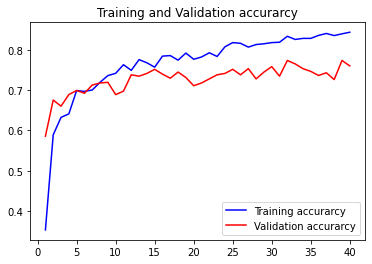

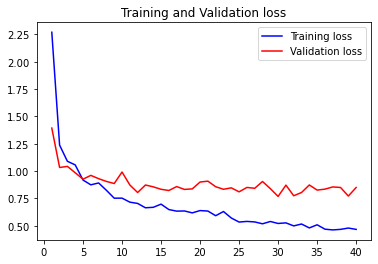

In [27]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

In [30]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
accuracy = scores[1] * 100
y_pred = model.predict(x_test)
precision = precision_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='weighted')
recall = recall_score(y_test.argmax(axis=1), y_pred.argmax(axis=1), average='weighted')

print(f"Test Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall Score: {recall}")

[INFO] Calculating model accuracy
19/19 [==============================] - 0s 24ms/step - loss: 0.8505 - accuracy: 0.7597
Test Accuracy: 75.9729266166687
Precision: 0.7731486873912964
Recall Score: 0.7597292724196277


In [ ]:
filename = 'finalized_model.sav'
pickle.dump(model, open(filename, 'wb'))